<a href="https://colab.research.google.com/github/19kubyshko88/finam-scraper/blob/master/Strimchik_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение потенциально популярных игр на 2017 г для интернет-магазина "Стримчик"

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности и дать рекомендации о том, какой продукт потенциально будет популярен в следующем году, для того чтобы спланировать рекламные кампании.

# Получение данных

Изучим данные, предоставленные сервисом для проекта.

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import re

Прочитаем файл *games.csv* и сохраним его в переменной *df*. 

In [ ]:
df = pd.read_csv('/datasets/games.csv') 

FileNotFoundError: ignored

Получение первых 10 строк таблицы.

In [ ]:
df.head(10)

## Общая информация о данных таблицы *df*.




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Рассмотрим полученную информацию подробнее.

Всего в таблице 11 столбцов, у пяти тип данных - object, остальные - float.
Подробно разберём, какие в *df* столбцы и какую информацию они содержат:

1. Name — название игры
2. Platform — платформа
3. Year_of_Release — год выпуска
4. Genre — жанр игры
5. NA_sales — продажи в Северной Америке (миллионы долларов)
6. EU_sales — продажи в Европе (миллионы долларов)
7. JP_sales — продажи в Японии (миллионы долларов)
8. Other_sales — продажи в других странах (миллионы долларов)
9. Critic_Score — оценка критиков (от 0 до 100)
10. User_Score — оценка пользователей (от 0 до 10)
11. Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Количество значений в столбцах различается. Это говорит о том, что в данных есть None значения.



## **Выводы**

Каждая строка таблицы содержит информацию об играх различных платформ: год выпуска, жанр, выручки от продаж в разных регионах,  оценки пользователей и критиков, рейтинг. 
Четыре проблемы нужно решить: 
- заменить названия столбцов, 
- исправить неверные типы данных, 
- устранить пропуски данных, 
- посчитать суммарные продажи во всех регионах и записать их в отдельный столбец. 

Для проверки рабочих гипотез особенно ценны столбцы *platform*, продажи по регионам и *user_score*. Данные из столбца *genre* позволят узнать самые популярные жанры.

# Предобработка данных

Переименуем столбцы, обработаем пропуски а также проверим данные на наличие дубликатов.

## Переименование столбцов

Получаем перечень названий столбцов.


In [ ]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

В названиях столбцов есть строчные и заглавные буквы, что не очень удобно при работе.

Переименуем столбцы для удобства дальнейшей работы. Проверим результат.



In [ ]:
columns_names = [name.lower() for name in df.columns]

In [ ]:
df.set_axis(columns_names,axis = 'columns',inplace = True)

In [ ]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

## Работа с пропусками

Проверим данные на наличие пропусков вызовом набора методов для суммирования пропущенных значений.

In [ ]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Пустые значения свидетельствуют, что для некоторых игр доступна не вся информация. Причины могут быть разные: скажем, игра не попала ни в один рейтинг из-за маленьких продаж или раньше просто не было никаких рейтингов. Хуже, если проблемы с записью данных. Каждый отдельный случай необходимо разобрать и выявить причину. В столбцах, где мало пропущенных данных, просто удалим эти строки, где категориальные данные (rating) заменим на unknown, а количественные (critic_score и user_score) либо на среднее, либо оставим None.

### Обнаружение и удаление пропусков с малой долей в общем количестве данных

In [ ]:
#Посчитаем количество пропусков в столбцах в процентах
df.isnull().sum()/df.shape[0]*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

Т.к. в столбцах 'name', 'year_of_release' и 'genre' количество пропусков незначительно, исключим строки с отсутствующими данными
из датасета.

In [ ]:
# <удаление пропущенных значений в столбце 'genre'>
df.dropna(subset = ['name','year_of_release','genre'], inplace = True)

In [ ]:
df.isnull().sum()/df.shape[0]*100

name                0.000000
platform            0.000000
year_of_release     0.000000
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.453418
user_score         40.166626
rating             40.598395
dtype: float64

Процент строк с пропущенными данными в столбцах 'critic_score', 'user_score' и 'rating' даже немного увеличился и составляет значительную часть данных - просто удалить их не получится. В 'critic_score' и 'user_score' замена такого большого процента данных на среднее может исказить результаты исследования, поэтому None ставим, как есть. Но необходимо разобраться с object в user_score 

### Заполнение NaN в столбце 'rating'

Неизвестные значения 'rating' заполним значением 'unknown'.

In [ ]:
# <замена пропущенных значений в столбце 'rating' на строку 'unknown'
df['rating']=df['rating'].fillna('unknown')

In [ ]:
df.isnull().sum()/df.shape[0]*100

name                0.000000
platform            0.000000
year_of_release     0.000000
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.453418
user_score         40.166626
rating              0.000000
dtype: float64

### Поиск дубликатов

Необходимо установить наличие дубликатов.  Если найдутся, удаляем, и проверяем, все ли удалились. Искать будем по имени, платформе и году выпуска.

In [ ]:
df[df.loc[:, ['name', 'platform','year_of_release']].duplicated()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.0,0.0,83.0,5.5,E


Найден один дубликат. Взглянем на него

In [ ]:
df.loc[(df['name']=='Madden NFL 13') & (df['platform']=='PS3') & (df['year_of_release']==2012)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [ ]:
# удаление всех дубликатов из таблицы df
df.drop([604, 16230], inplace=True)

In [ ]:
df.loc[:, ['name', 'platform','year_of_release']].duplicated().sum()

0

### Добавление столбца с суммарными продажами во всех регионах 

Проблем со столбцами продаж нет, поэтому создадим столбец с суммой продаж

In [ ]:
df['world_sales'] = df['na_sales']+ df['eu_sales']+ df['jp_sales']+ df['other_sales']

In [ ]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


### Замена типа данных в столбцах

Заменим тип данных в столбце year_of_release на int

In [ ]:
df['year_of_release']=df['year_of_release'].astype('int64')


**Столбец "user_score"** 

Найдём в user_score значения, которые являются str, но не могут быть сконвертированы в рейтинг (т.е. не подходят под шаблон неотрицательного целого или дробного числа с одним знаком после точки)

In [ ]:
[i for i in df['user_score'].unique() if type(i)== str and not (re.fullmatch(r'[0-9]+\.*[0-9]*', i))]

['tbd']

В user_score есть строки со значением 'tbd' , которые мешают нам конвертировать данные в числа.  
TBD - to be decided or to be determined. Видимо эту абревиатуру используют, когда рейтинг не набрал нужное количество голосов.

*Определим количество и значимость строк со значением 'tbd' в столбце user_score*

In [ ]:
tbd_cells_count = df.query('user_score == "tbd"').count()['user_score']
print(f'Количество строк со значением "tbd" в user_score: {tbd_cells_count}')
print(f"Что составляет {tbd_cells_count/df.shape[0]*100:.1f}% от общего числа строк")

Количество строк со значением "tbd" в user_score: 2376
Что составляет 14.5% от общего числа строк


Узнаем какую долю в процентах занимаю строки с 'tbd' от общего числа продаж.

In [ ]:
tbd_sales = df.query('user_score == "tbd"').sum()[['na_sales', 'eu_sales', 'jp_sales', 'world_sales']]

In [ ]:
all_sales = df.sum()[['na_sales', 'eu_sales', 'jp_sales', 'world_sales']]

In [ ]:
tbd_sales/all_sales*100

na_sales         6.8739
eu_sales        4.32474
jp_sales       0.512149
world_sales      5.0665
dtype: object

Строки помеченные 'tbd' составляют чуть более 5% от общего объема продаж

Построим графики продаж игр с отметкой 'tbd'

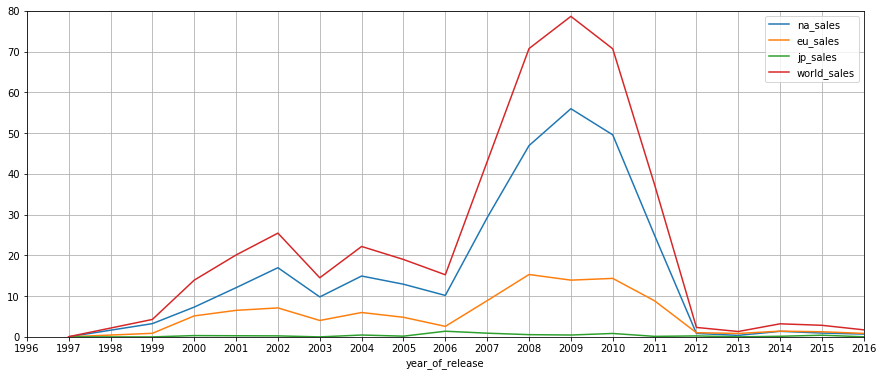

In [ ]:
df.query('user_score == "tbd"')\
.groupby('year_of_release').sum()[['na_sales', 'eu_sales', 'jp_sales', 'world_sales']]\
.plot(grid =True,
      figsize = (15,6), 
      xlim=(1996, 2016), 
      ylim=(0, 80),
      xticks=sorted(df['year_of_release'].unique()))

Так же видим, что после 2012го года суммы от продаж игр с user_score = "tbd" составляют незначительное количество. 
Поэтому исключим строки user_score = "tbd" из датасета.

In [ ]:
df = df.query('user_score != "tbd"')

Проверим наличие tbd

In [ ]:
df.query('user_score == "tbd"')['user_score'].size

0

Заменим типы данных в столбце user_score на float

In [ ]:
df['user_score']=df['user_score'].astype('float64')

In [ ]:
df['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Видно, что всё является числами или nan

Получаем общую информацию о данных. Убеждаемся, что чистка выполнена успешно.

In [ ]:
# <получение общей информации о данных таблицы df>
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14066 entries, 0 to 16714
Data columns (total 12 columns):
name               14066 non-null object
platform           14066 non-null object
year_of_release    14066 non-null int64
genre              14066 non-null object
na_sales           14066 non-null float64
eu_sales           14066 non-null float64
jp_sales           14066 non-null float64
other_sales        14066 non-null float64
critic_score       6925 non-null float64
user_score         7461 non-null float64
rating             14066 non-null object
world_sales        14066 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.4+ MB


Около половины значений столбцов critic_score и user_score отсутствуют. Удаление такого количества данных или замена их на 
среднее значительно повлияет на выявляемые закономерности. Восстановить пропущенные значения мы не можем. Данных для этого недостаточно. Лучше работать с меньшим количеством данных хорошего качества. Поэтому оставляем как есть.

## **Выводы**

На этапе предобработки в данных обнаружились не только пропуски и проблемы с названиями столбцов, но и скрытые дубликаты. Их удаление позволит провести анализ точнее. Поскольку около половины данных о рейтингах критиков и пользователей отсутствуют и при этом ни заполнить, ни удалить их  мы не можем, то оставляем столбцы и строки, как есть. Имена столбцов теперь корректны и удобны для дальнейшей работы.

Ошибки в данных устранены. Данные подготовлены к дальнейшему анализу.

---

---







---

---







<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Восстановить пропущенные значения мы не можем. Данных для этого недостаточно. Лучше работать с меньшим количеством данных хорошего качества.
    
Ошибки в данных устранены. Данные подготовлены к дальнейшему анализу. 

</div>

# Исследовательский анализ

### Сколько игр выпускалось в разные годы

Text(0, 0.5, 'platform_count')

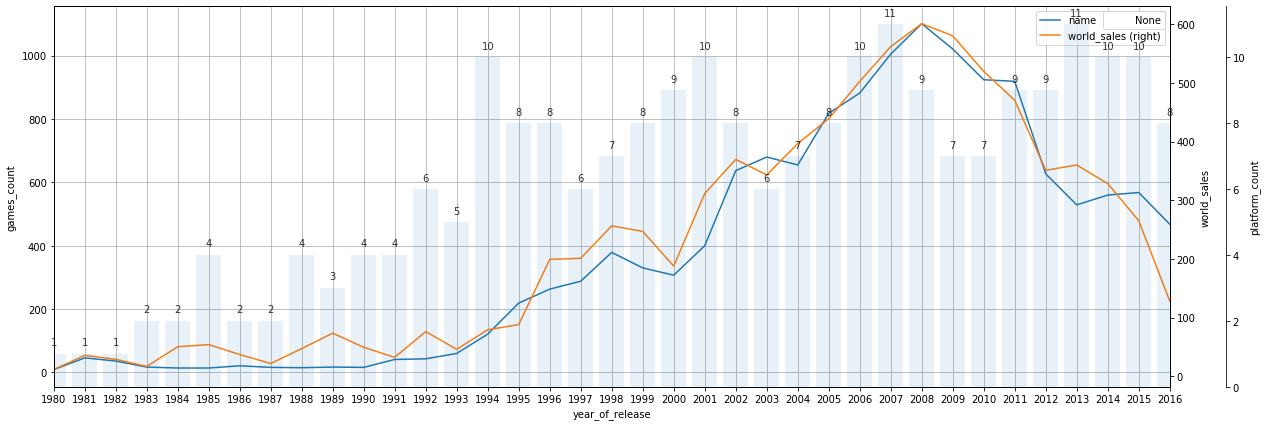

In [ ]:

fig, ax = plt.subplots()

# график количества игр по годам
df_year_games = df.groupby('year_of_release').count()['name'].plot(kind = 'line',
                                                                   ax =ax, 
                                                                   legend= True)


# график мировых продаж по годам
df_year_w_sales = df.groupby('year_of_release').sum()['world_sales']\
                                  .plot(kind = 'line',
                                        ax =ax, 
                                        secondary_y=True, 
                                        legend= True, 
                                       
                                        figsize=(20,7),
                                        xticks=df['year_of_release'].unique(), 
                                        grid =True)

#количество платформ по годам
ax3 = df_year_games.twinx()
ax3.spines['right'].set_position(('axes', 1.05)) # смещение третьей вправо оси

# таблица количества платформ по годам
platform_count_by_year = df.pivot_table(values="world_sales",
                                        columns="year_of_release",
                                        index="platform", 
                                        aggfunc = 'count').count()

# строим барный график количества платформ по годам
platform_count_by_year_plot = platform_count_by_year.plot(stacked=True, 
                                                          y = platform_count_by_year, 
                                                          legend= True, 
                                                          
                                                          ax=ax3, 
                                                          alpha =0)
plt.bar(sorted(df['year_of_release'].unique()), platform_count_by_year,  alpha =0.1)

# делаем надписи над столбцами баров
for x, y in zip(sorted(df['year_of_release'].unique()), platform_count_by_year.tolist()):
      platform_count_by_year_plot.text(x, y+0.5, y, ha='center', va = 'top', alpha = 0.8)

# подписываем вертикальные оси
df_year_games.set_ylabel('games_count')
df_year_w_sales.set_ylabel('world_sales')
platform_count_by_year_plot.set_ylabel('platform_count')


Виден всплеск количества платформ в 1994 и последующий рост количества игр и продаж после 1994-1995 годов. Видимо в 1994г производители решили вложиться в игры, что породило разнообразие различных платформ и последующий рост количества игр в 1995г и рост выручки в 1996 году. Далее видно зигзагообразное изменение количества платформ. Видимо старые и неудачные платформы отмирали, затем появлялись новые. 





В 2008 году был пик популярности видеоигр. С тех пор их количество и сборы неуклонно падают, хотя количество платформ не сильно падает. В 2008 году был мировой финансовый кризис, но вряд ли он до 2016 года имел столь сильное влияние. Скорее всего падение связано с возникновением новых конкурентов, которые отобрали большую долю игрового рынка. Как раз в 2007 г Apple выпустила iPhone, а в 2008 вышел первый аппарат на Android и с тех пор почти у каждого в кармане появилась своя небольшая игровая приставка. Видимо, "Стримчику" стоит задуматься о своём будущем и проанализировать рынок игр для мобильных устройств.


---



## Анализ по платформам

Производство игр для различных платформ по годам.

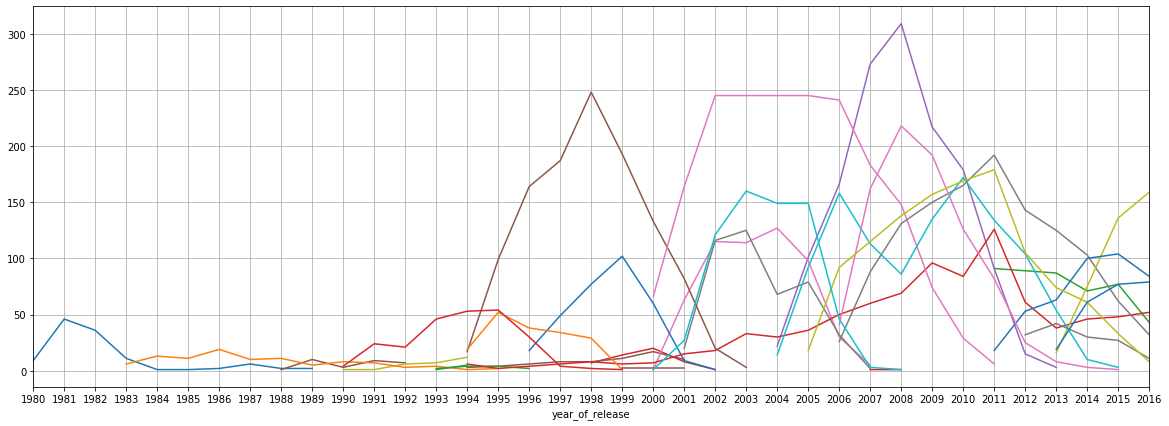

In [ ]:
#количество игр выпущенное различными платформами по годам
df_count_of_games_by_year=df.pivot_table(values="name",
                                         columns="platform",
                                         index="year_of_release", 
                                         aggfunc= 'count')
df_count_of_games_by_year.plot(xlim= (1980,2016),
                               figsize=(20,7),xticks=sorted(df['year_of_release'].unique()), 
                               grid =True, legend = False)

Видим, что есть, как "долгожители", так и платформы, прожившие три-четыре года.

### Определим время жизни платформ

Создадим таблицу с продолжительностью жизни платформ

In [ ]:
df_count_of_games_by_year.columns

Index(['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64',
       'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV',
       'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360', 'XB',
       'XOne'],
      dtype='object', name='platform')

In [ ]:
def life_time_df(data):
  lifetime_df = pd.DataFrame()
  for i in data.columns: # для каждой платформы
    # последний год жизни = максимальный год в таблице
    last_year_life =  data[i].dropna().index.max()
    # первый год жизни
    first_year_life = data[i].dropna().index.min()
    # время жизни =  последний год - первый год жизни + 1
    lifetime_df.loc[i,'life_time']= last_year_life - first_year_life + 1
  return lifetime_df

df_games_lifetime = life_time_df(df_count_of_games_by_year)

# описание полученных данных
df_games_lifetime.describe()

,life_time
count,31.000000
mean,8.580645
std,6.989393
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,32.000000


Максимальное время жизни платформы получилось 32 года. Слишком долго, п.ч. учитываются периоды, когда выпускалось по одной игре раз в несколько лет, например для PC. Посчитаем время жизни, но не будем учитывать данные до 1994г и платформы, срок жизни которых еще не окончен (т.е. есть прибыль в 2016г). Также для расчета среднего срока жизни платформы исключим из расчетов те, которые прожили 1 год (будем считать, что они неудачные) и "бессмертную" платформу PC.

In [ ]:
# "живые" в 2016г платформы
platform_2016 = df.query('year_of_release==2016 & world_sales>=0.1')['platform'].unique()
platform_2016

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'PC', 'X360', 'PSV'],
      dtype=object)

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюера</b></font>

Значение средней продолжительности существования платформы приведено. Однако в анализ ты включил актуальные на настоящий момент платформы. Делать этого не стоит, т.к. период их жизни еще продолжается.

</div>

In [ ]:
#фильтруем по дате и удаляем столбцы платформ, у которых нет игр после 1994г и еще "живые" в 2016г, в т.ч. PC
df_count_of_games_from_1994 = df_count_of_games_by_year.query('year_of_release > 1993')\
                                                                .dropna(axis='columns',how='all')\
                                                                .drop(platform_2016, axis =1)
                                                                

In [ ]:
#удаляем столбцы у которых срок жизни 1 год 
df_count_of_games_filtred = df_count_of_games_from_1994[df_count_of_games_from_1994
                                                      .count()[df_count_of_games_from_1994
                                                               .count()>1].index]

Пересчитаем продолжительность жизни платформ с учётом внесенных изменений

In [ ]:
df_games_lifetime = life_time_df(df_count_of_games_filtred)

# описание полученных данных
df_games_lifetime.describe()

,life_time
count,16.000000
mean,7.750000
std,3.151719
min,2.000000
25%,6.000000
50%,8.000000
75%,10.000000
max,12.000000


Среднее время жизни платформы 7,8 лет. Медианное - 8 лет. Максимальное: 12. Минимум 2 года

### Как часто появлялись новые платформы

In [ ]:
df_count_of_games_from_1994.head()

platform,3DO,DC,DS,GB,GBA,GC,GEN,N64,NES,NG,...,PS,PS2,PSP,SAT,SCD,SNES,TG16,WS,Wii,XB
year_of_release,,,,,,,,,,,,,,,,,,,,,
1994,1.0,NaN,NaN,3.0,NaN,NaN,12.0,NaN,1.0,4.0,...,17.0,NaN,NaN,19.0,5.0,53.0,NaN,NaN,NaN,NaN
1995,2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,...,99.0,NaN,NaN,52.0,NaN,54.0,2.0,NaN,NaN,NaN
1996,NaN,NaN,NaN,6.0,NaN,NaN,NaN,18.0,NaN,2.0,...,164.0,NaN,NaN,38.0,NaN,30.0,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,8.0,NaN,NaN,NaN,49.0,NaN,NaN,...,187.0,NaN,NaN,34.0,NaN,4.0,NaN,NaN,NaN,NaN
1998,NaN,7.0,NaN,8.0,NaN,NaN,NaN,77.0,NaN,NaN,...,248.0,NaN,NaN,29.0,NaN,2.0,NaN,NaN,NaN,NaN


In [ ]:
#список, в который запишем периоды возникновения новых платформ
years_from_new_platform_list = [] 

#список, в который запишем периоды исчезновения новых платформ
years_from_platform_dead_list = []

#переменные для подсчета лет появления и исчезновения платформ
years_from_born, years_from_death = [0,0]

# год предыдущего появления новой платформы. Изначально равен первому году в таблице
year_of_last_born = df_count_of_games_from_1994.index.min()

# год предыдущего исчезновения платформы также возмем равным первому году в таблице
year_of_last_death = year_of_last_born

# пробегаемся по строкам и смотрим
for year in range(df_count_of_games_from_1994.index.min()+1,df_count_of_games_from_1994.index.max()):
    
  # если в текущем году больше платформ, чем в предыдущем, то
  if df_count_of_games_from_1994.loc[year].count()>df_count_of_games_from_1994.loc[year-1].count():
        
     # добавляем в список, сколько лет прошло с предыдущего появления новой платформы:
     years_from_new_platform_list.append(year - year_of_last_born)
        
     # Запоминаем год рождения
     year_of_last_born =  year
        
  #если  же в текущем году меньше платформ, чем в предыдущем, то
  elif df_count_of_games_from_1994.loc[year].count()<df_count_of_games_from_1994.loc[year-1].count():
        
     # добавляем в список, сколько лет прошло с предыдущего исчезновения платформы:
     years_from_platform_dead_list.append(year - year_of_last_death)
        
     # Запоминаем год исчезновения
     year_of_last_death =  year
        
print(f'{years_from_new_platform_list} - как часто платформы появляются')
print(f'{years_from_platform_dead_list} - как часто платформы исчезают')



[4, 1, 1, 1, 3, 2, 1] - как часто платформы появляются
[1, 2, 5, 1, 5, 1, 3, 2] - как часто платформы исчезают


Полученные цифры легко проверить на графике с количеством платформ по годам

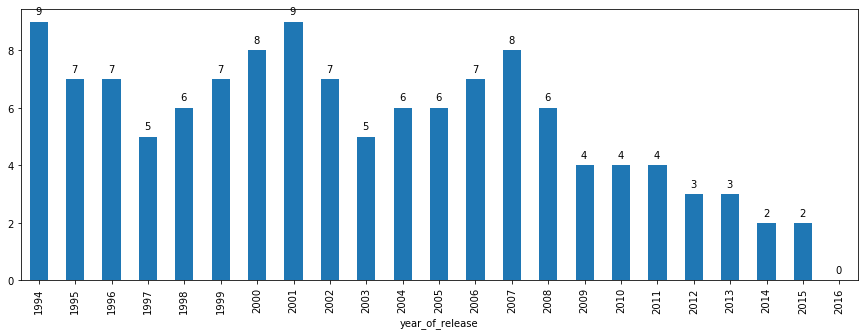

In [ ]:
df_count_of_games_from_1994.count(axis=1)

ax = df_count_of_games_from_1994.count(axis=1).plot(kind ='bar', figsize = (15,5))
for p in ax.patches:
    b = p.get_bbox()
    val = f'{b.y1 + b.y0:.0f}'        
    ax.annotate(val, ((b.x0 + b.x1)/2-0.1, b.y1 + 0.25))

### Продажи по платформам

Посчитаем количество выпущенных игр для каждой платформы 

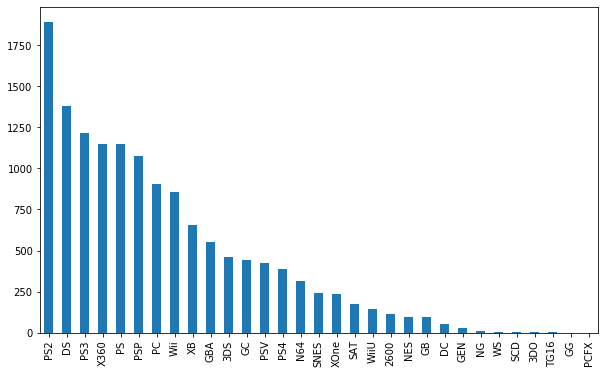

In [ ]:
df_platrofm_game_count = df['platform'].value_counts()
df_platrofm_game_count.plot(kind='bar',figsize=(10,6))

Прибыль от продаж:

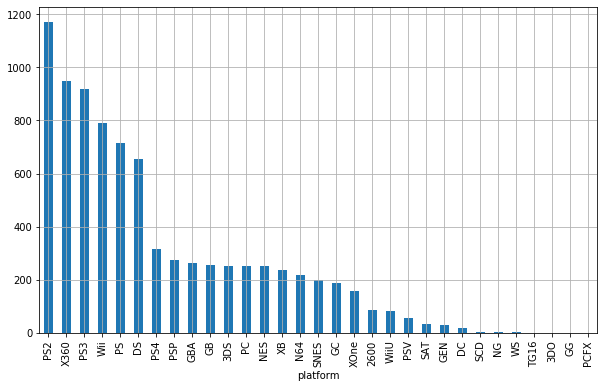

In [ ]:
df_platform_sales = df.groupby('platform')["world_sales"].sum().sort_values(ascending = False)
df_platform_sales.plot(kind = 'bar',figsize=(10,6), grid = True)

Выделяются 6 лидеров продаж: PS2, X360, PS3, Wii, PS и DS. Видим, что количество игр не всегда определяем высокие прибыли для платформы. Также нужно взглянуть на распределение прибыли по годам, чтобы понять, как дела у них в 2016г.

### Продажи для различных платформ по годам:

Взглянем в общем на данные по платформам по всем годам.

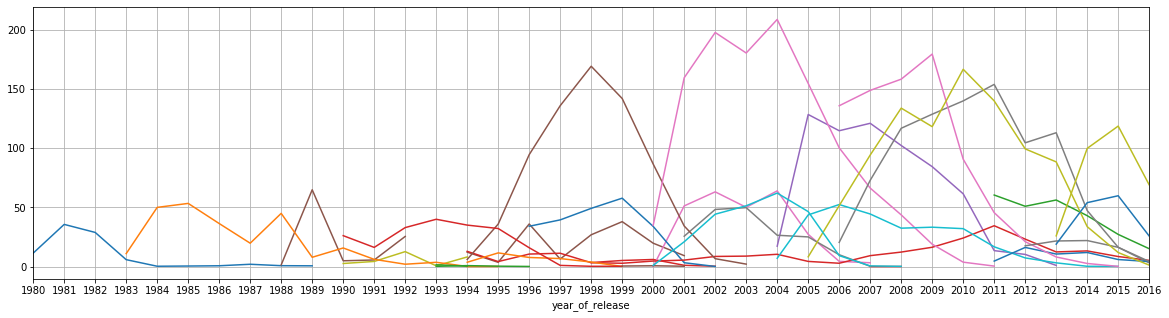

In [ ]:
#продажи для различных платформам по годам
df.pivot_table(values="world_sales",
               columns="platform",
               index="year_of_release", 
               aggfunc= 'sum').plot(xlim= (1980,2016),
                                    figsize=(20,5),
                                    xticks=sorted(df['year_of_release'].unique()), 
                                    grid =True, 
                                    legend = False)

Видно, что в 1994 г появилась платформа,"касса" которой до 2000го года значительно превышала конкурентов. Затем пришел новый лидер. С 2006го появились конкуренты, которые и стали делить основные доходы.


### Распределение продаж по годам для шести самых прибыльных платформ

In [ ]:
df.pivot_table(values="world_sales",
               columns="platform",
               index="year_of_release")[df_platform_sales[:6].index]

platform,PS2,X360,PS3,Wii,PS,DS
year_of_release,,,,,,
1980,NaN,NaN,NaN,NaN,NaN,NaN
1981,NaN,NaN,NaN,NaN,NaN,NaN
1982,NaN,NaN,NaN,NaN,NaN,NaN
1983,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,0.020000
1986,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN


Интересно, что для платформы DS  в 1985 году было продано игр на 0.02 млн, хотя если верить википедии Nintendo DS вышла в 2004г. Либо я чего-то не заю, либо это ошибка базы данных. Но т.к. сумма незначительная, проигнорируем данный факт. Для наглядности построим графики распределения прибыли на платформах по годам для для шести лидеров продаж, начиная с 1994 г.

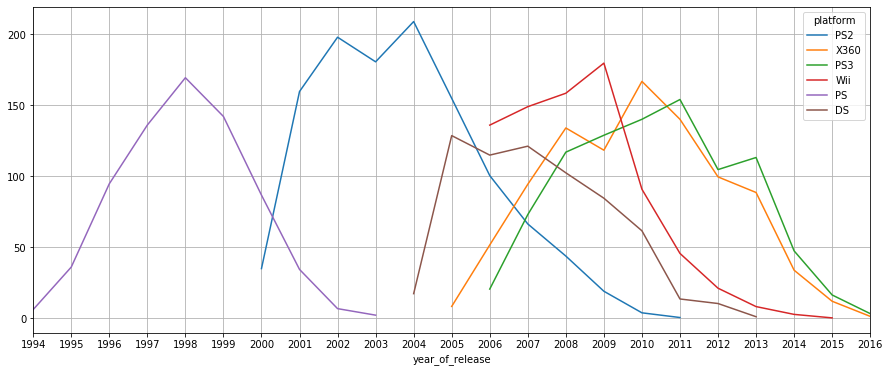

In [ ]:
df.pivot_table(values="world_sales",
               columns="platform",
               index="year_of_release", 
               aggfunc='sum')[df_platform_sales[:6].index]\
.plot(xlim= (1994,2016),figsize=(15,6),xticks=sorted(df['year_of_release'].unique()), grid =True)

На графике хорошо видно, что все лидеры прошлых лет находятся в стадии завершения жизненного цикла. И, повидимому, им пришли на смену новые платформы.

### Платформы у которых в 2016г продажи на нуле

In [ ]:
df_2016 = df.pivot_table(values="world_sales",
                         columns="platform",
                         index="year_of_release", 
                         aggfunc='sum').loc[2016]
df_2016[df_2016.isna()].index

Index(['2600', '3DO', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64', 'NES',
       'NG', 'PCFX', 'PS', 'PS2', 'PSP', 'SAT', 'SCD', 'SNES', 'TG16', 'WS',
       'Wii', 'XB'],
      dtype='object', name='platform')

### Определение потенциально прибыльных платформ

Платформы с продажами в 2016г

In [ ]:
df_2016[df_2016.notna()].drop('PC')

platform
3DS     15.10
PS3      3.16
PS4     69.15
PSV      4.24
WiiU     4.30
X360     1.22
XOne    25.82
Name: 2016, dtype: float64

Определим платформы не сильно старые (исключим 'PC', 'PS3' и 'X360') и продающиеся в 2016г.

In [ ]:
df_2016_notna = df.query('year_of_release>1993').pivot_table(values="world_sales",
                                                             columns="platform",
                                                             index="year_of_release", 
                                                             aggfunc= 'sum')\
[df_2016[df_2016.notna()].drop(['PC', 'PS3', 'X360']).index]\
.dropna(axis =0, how ='all')

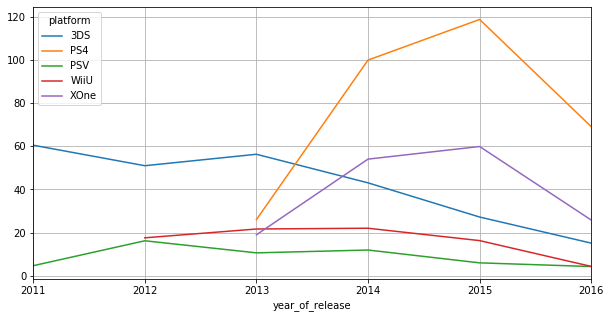

In [ ]:
df_2016_notna.plot(grid =True, figsize = (10,5))

Среди найденных платформ наиболее перспективны PS4 и XOne. У остальных продажи ниже и срок жизни приближается к среднему.

## «Ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам 

Уберем из датафрейма данные до 1994г.

In [ ]:
df_1994 = df.query('year_of_release >1993').reset_index()

In [ ]:
df_1994.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13701 entries, 0 to 13700
Data columns (total 13 columns):
index              13701 non-null int64
name               13701 non-null object
platform           13701 non-null object
year_of_release    13701 non-null int64
genre              13701 non-null object
na_sales           13701 non-null float64
eu_sales           13701 non-null float64
jp_sales           13701 non-null float64
other_sales        13701 non-null float64
critic_score       6922 non-null float64
user_score         7458 non-null float64
rating             13701 non-null object
world_sales        13701 non-null float64
dtypes: float64(7), int64(2), object(4)
memory usage: 1.4+ MB


Диаграмма размаха по глобальным продажам игр

In [ ]:
df_1994['world_sales'].describe()

count    13701.000000
mean         0.568215
std          1.581506
min          0.000000
25%          0.060000
50%          0.180000
75%          0.520000
max         82.540000
Name: world_sales, dtype: float64

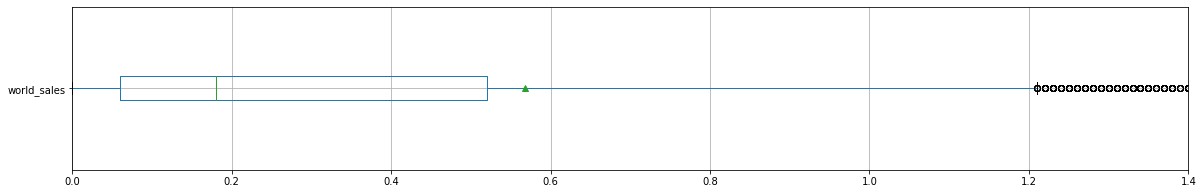

In [ ]:
df_1994.boxplot(column='world_sales', figsize=(20,3), vert=False, showmeans =True)
plt.xlim(0, 1.4)
plt.show()



Средние по миру продажи за игру - 0,56млн - получились на много больше медианных продаж - 0,18 млн- и даже выше третьей квартили. Большое стандартное отклонение. Значит сборы игр раcпределены очень неравномерно.

Медианные продажи каждой игры в районе 0,18 млн долларов по миру. 50% игр зарабатывает в диапазоне от 0,06 до 0,52 млн.


---

---





**Продажи игр сгруппированные по платформам**

Средние доходы игр по платформам

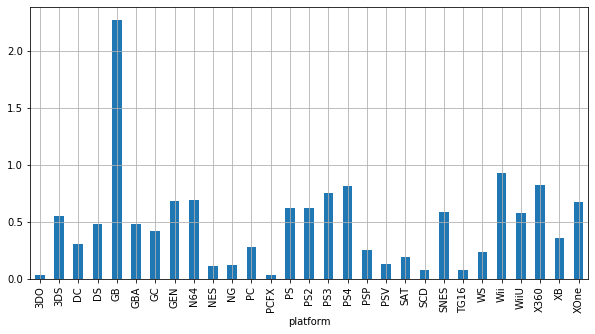

In [ ]:
ax = df_1994.groupby('platform')['world_sales'].mean().plot(kind = 'bar', 
                                                              grid = True, 
                                                              figsize = (10,5))

(0, 4)

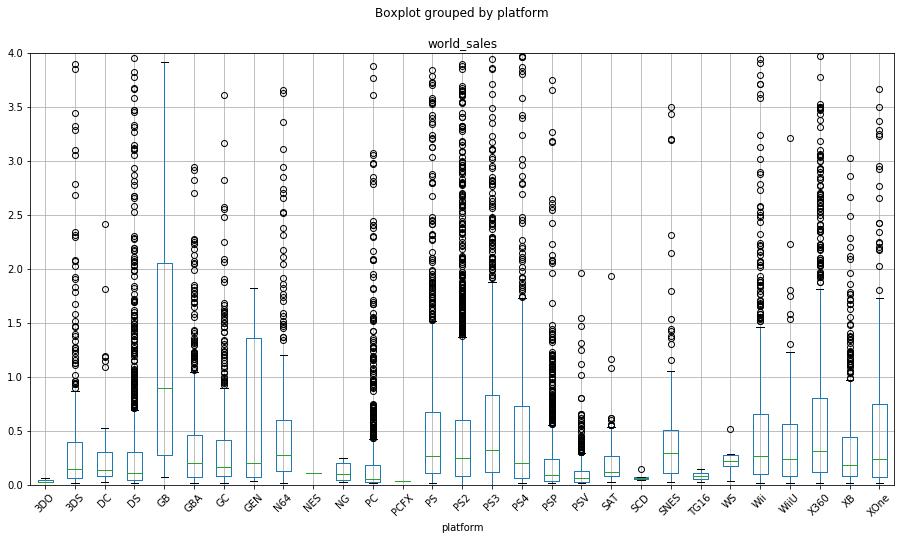

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) # Скрываем некрасивое предупреждение
df_1994.boxplot(column= 'world_sales',by = 'platform', rot=45, figsize=(15,8))
plt.ylim(0, 4)

Очень выделяется платформа GB. Основная масса их игр сделала большие сборы по миру, но, тем не менее, эта платформа не входит в топ-6 лидеров продаж.

Посмотрим на лидеров продаж и продающиеся в 2016г платформы

In [ ]:
# лидеры продаж прошлых лет
ind = list(df_platform_sales[:6].index)
print(ind)

['PS2', 'X360', 'PS3', 'Wii', 'PS', 'DS']


(0, 2)

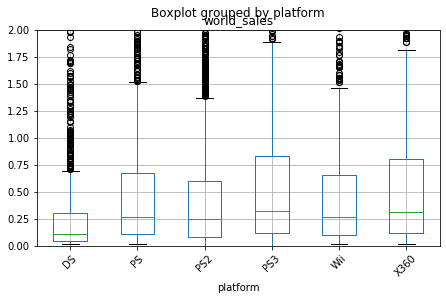

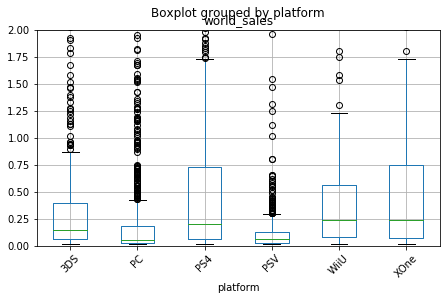

In [ ]:
df_1994[df_1994['platform'].isin(ind)].boxplot(column=['world_sales'],
                                                   by = 'platform', 
                                                   rot=45, 
                                                   figsize=(7,4))
plt.ylim(0, 2)
df_1994[df_1994['platform'].isin(list(df_2016_notna.columns)+['PC'])].boxplot(column='world_sales',
                                                   by = 'platform', 
                                                   rot=45, 
                                                   figsize=(7,4))
plt.ylim(0, 2)

'DS', 'PS', 'PS2',  'PS3', 'Wii', 'X360'   - лидеры продаж прошлых лет

'3DS', 'PS4', 'PSV', 'WiiU', 'XOne' - "живые" в 2016г платформы

'PC' - "бессмертная" платформа.

Сборы у похожих платформ похожи: портативные игровые платформы DS, 3DS, PC и PSV зарабатывают меньше, чем домашние консоли. PSV и PC выделились довольно низкими сборами.
Домашние консоли разных поколений и производителей собирали в основном похожие суммы.

## Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков

In [ ]:

df_cutted =df.query('year_of_release >2011').reset_index()

Для продаваемых в 2016г платформ построим графики зависимости продаж от рейтингов критиков и пользователей, начиная с 2012г.

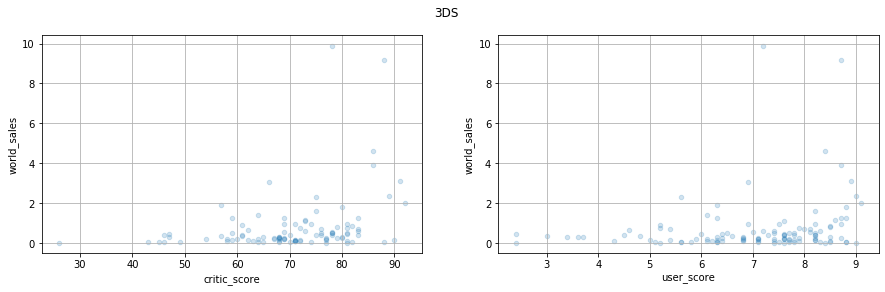

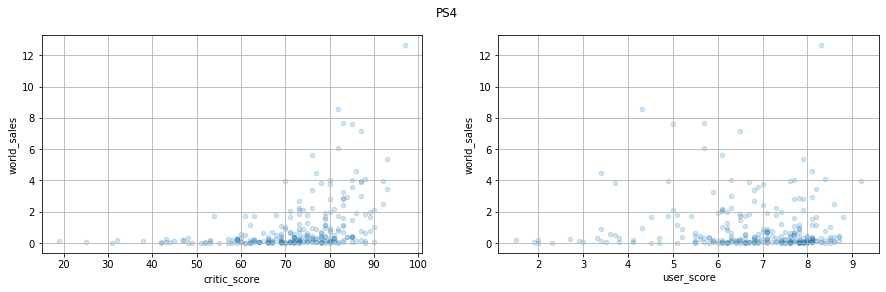

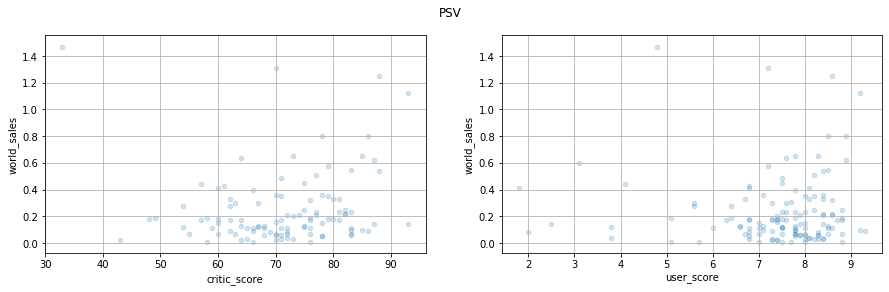

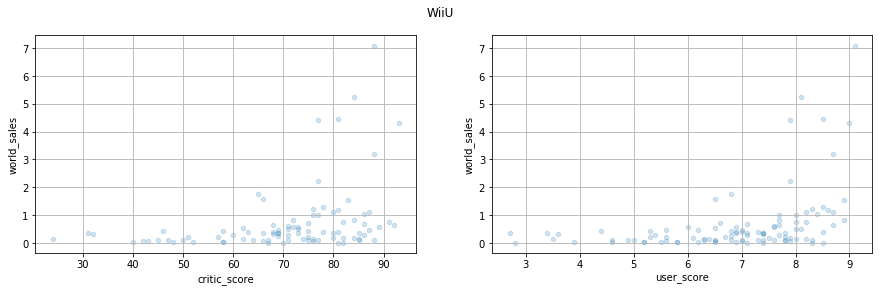

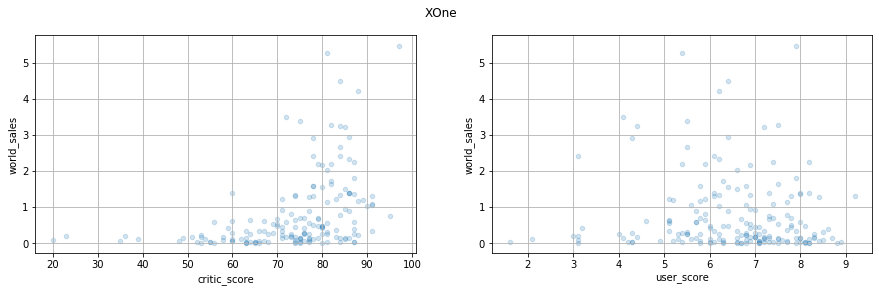

In [ ]:
# для живых в 2016 г платформ 
for pltfrm in df_2016_notna.columns:
    
    plt.suptitle(pltfrm) # заголовок
    
    ax = plt.subplot(1,2,1)
    df_cutted[df_cutted['platform'] == pltfrm].plot(x='critic_score', 
                                                 y='world_sales',
                                                 kind='scatter',
                                                 ax= ax,
                                                 grid =True, 
                                                 alpha=0.2, figsize = (15,4))
   
    
    ax1 =plt.subplot(1,2,2)
    df_cutted[df_cutted['platform'] == pltfrm].plot(x='user_score', 
                                                 y='world_sales',
                                                 kind='scatter',
                                                 ax= ax1,
                                                 grid =True, 
                                                 alpha=0.2)
    
    plt.show()

Точки на графике в основном ложатся ближе к "дну", слабо завися от рейтинга. Также видно, что у рейтинга критиков чуть более правильная диаграмма, хотя тоже далеко не идеальная для предсказания продаж. Что говорит о несильной зависимость прибыли от отзывов критиков. Некоторые игры неплохо "хайпанули" и заработали, несмотря даже на низкие рейтинги, а некоторых наоборот - не спас и высокий рейтинг.

Посчитаем коэффициент корреляции Пирсона.

In [ ]:
print("Коэффициенты кореляции рейтингов критиков и продаж:")
for pltfrm in df_2016_notna.columns:
    corr_k = df_cutted[df_cutted['platform']==pltfrm]['critic_score'].corr(df_cutted['world_sales'])
    print(f"{pltfrm}: {corr_k:.2f}")

Коэффициенты кореляции рейтингов критиков и продаж:
3DS: 0.31
PS4: 0.41
PSV: 0.09
WiiU: 0.35
XOne: 0.41


In [ ]:
print("Коэффициенты кореляции рейтингов пользователей и продаж:")
for pltfrm in df_2016_notna.columns:
    corr_k = df_cutted[df_cutted['platform']==pltfrm]['user_score'].corr(df_cutted['world_sales'])
    print(f"{pltfrm}: {corr_k:.2f}")

Коэффициенты кореляции рейтингов пользователей и продаж:
3DS: 0.20
PS4: -0.03
PSV: -0.00
WiiU: 0.40
XOne: -0.07


**Вывод.** 
Коэффициенты кореляции подтверждают ранее сделанные наблюдения о слабой зависимости продаж от рейтингов. Рейтинг пользователей почти не корелирует, а инода даже отрицательно.  Рейтинг критиков чуть лучше, но тоже слАбо. Среди рейтингов пользователей лишь WiiU дало сравнимую с критиками кореляцию. Видимо пользователи WiiU более искушенны в играх. Может быть рейтинг критиков дает немного больше кореляцию с продажами, п.ч. в некоторые игры вкладываются дополнительные деньги для продвижения, в том числе и для получения хороших отзывов от критиков? Также не все пользователи, купившие игры оставляют отзывы, что может приводить к дисбалансу рейтинга пользователей и критиков.

## Распределение игр по жанрам

In [ ]:
df_cutted.groupby('genre')['world_sales'].sum()

genre
Action          437.04
Adventure        28.50
Fighting         44.37
Misc             82.00
Platform         60.19
Puzzle            4.69
Racing           53.25
Role-Playing    192.80
Shooter         304.44
Simulation       34.56
Sports          177.36
Strategy         13.34
Name: world_sales, dtype: float64

(0, 2)

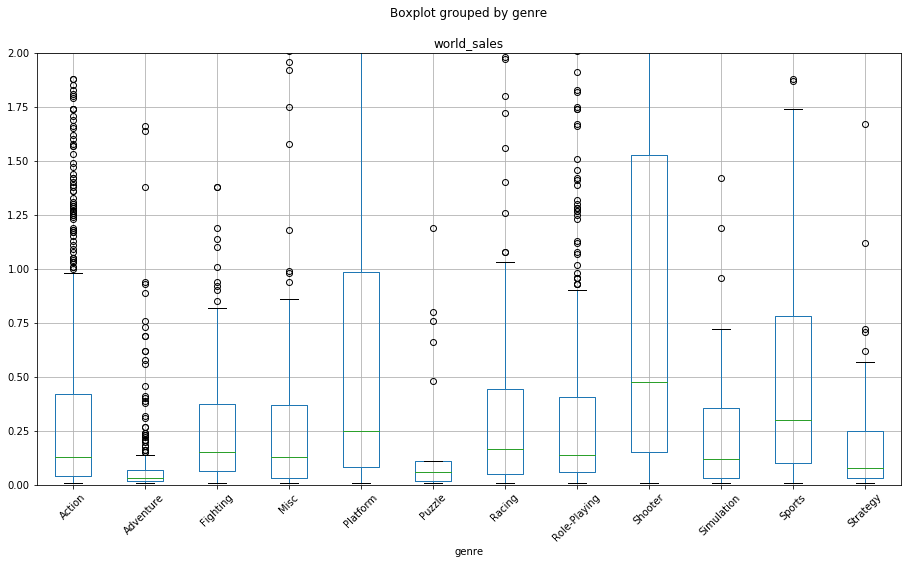

In [ ]:
df_cutted.boxplot(column= 'world_sales',by = 'genre', rot=45, figsize=(15,8))
plt.ylim(0, 2)

Платформеры, шутеры, гонки и спорт в почёте у игроков и за них готовы платить, а вот приключениям и стратежкам не очень-то и рады. Также у лидеров продаж медиана выше 0,25млн или почти 0,25 и правый "ус" выше 1,25 млн. Для меня также было интересно наблюдение, что пазлы зарабатывают побольше стратегий. Видимо родители готовы делать маленьким детям подарки.


# Портрет пользователя каждого региона

### Самые популярные платформы (топ-5).

In [ ]:
df_cutted.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
3,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
4,34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [ ]:
pivoted_platform = df_cutted.groupby(['platform'])['na_sales', 'eu_sales', 'jp_sales'].sum()
na_lider_patforms = pivoted_platform.sort_values(by = 'na_sales', ascending = False)['na_sales'][:5]
eu_lider_patforms = pivoted_platform.sort_values(by = 'eu_sales', ascending = False)['eu_sales'][:5]
jp_lider_patforms = pivoted_platform.sort_values(by = 'jp_sales', ascending = False)['jp_sales'][:5]
df_region_patform_liders = pd.DataFrame(data = [na_lider_patforms,eu_lider_patforms,jp_lider_patforms])
df_region_patform_liders

,X360,PS4,PS3,XOne,3DS,PSV,WiiU
na_sales,139.16,108.62,100.99,92.77,54.65,NaN,NaN
eu_sales,74.02,141.09,106.03,51.43,41.64,NaN,NaN
jp_sales,NaN,15.96,34.92,NaN,87.68,20.93,13.01


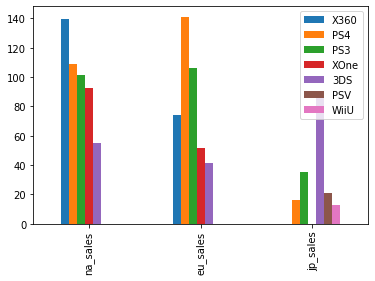

In [ ]:
df_region_patform_liders.plot(kind = 'bar')

Видим, что среди лидеров платформ в Японии не оказалось X360 и Wii. Зато там любят платформы Nintendo DS и 3DS. 
Также видно, что самый большой рынок продаж в Северной Америке. Для платформ X360 и  PS2 - ярких лидеров- продажи приблизительно в 2 раза больше, чем в Европе. Продажи в Японии также значительно меньше, чем в Европе.

### Самые популярные жанры (топ-5)

In [ ]:
pivoted_genre = df_cutted.groupby(['genre'])['na_sales', 'eu_sales', 'jp_sales', 'world_sales'].sum()
na_lider_genre = pivoted_genre.sort_values(by = 'na_sales', ascending = False)['na_sales'][:5]
eu_lider_genre = pivoted_genre.sort_values(by = 'eu_sales', ascending = False)['eu_sales'][:5]
jp_lider_genre = pivoted_genre.sort_values(by = 'jp_sales', ascending = False)['jp_sales'][:5]
df_region_genre_liders = pd.DataFrame(data = [na_lider_genre,eu_lider_genre,jp_lider_genre])
df_region_genre_liders

,Action,Shooter,Sports,Role-Playing,Misc,Racing,Simulation,Fighting
na_sales,176.39,144.64,79.02,64.00,36.90,NaN,NaN,NaN
eu_sales,157.51,113.33,68.46,48.53,NaN,27.19,NaN,NaN
jp_sales,52.33,NaN,NaN,65.44,12.86,NaN,10.35,9.41


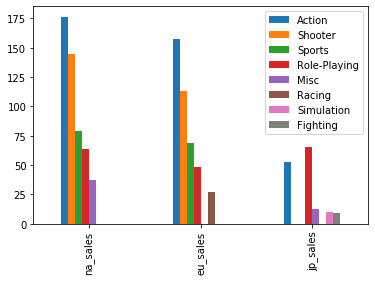

In [ ]:
df_region_genre_liders.plot(kind = 'bar')

В Европе и Северной Америке предпочтение отдают трем жанрам: Action, Sport и Shooter. В Японии сильно выделяется жанр Role-playing, а у остальных жанров продажи  в 2-3 раза меньше. Видимо, в силу каких-то культурных особенностей японцы больше любят ролевые игры.

### Влияние рейтинга ESRB на продажи по регионам

In [ ]:
pivoted_rating = df_cutted.groupby(['rating'])['na_sales', 'eu_sales', 'jp_sales', 'world_sales'].sum()
na_lider_rating = pivoted_rating.sort_values(by = 'na_sales', ascending = False)['na_sales'][:5]
eu_lider_rating = pivoted_rating.sort_values(by = 'eu_sales', ascending = False)['eu_sales'][:5]
jp_lider_rating = pivoted_rating.sort_values(by = 'jp_sales', ascending = False)['jp_sales'][:5]
df_region_rating_liders = pd.DataFrame(data = [na_lider_rating,eu_lider_rating,jp_lider_rating])
df_region_rating_liders

,M,E,unknown,E10+,T
na_sales,231.47,110.81,103.27,73.29,65.80
eu_sales,193.94,110.72,91.24,52.48,52.82
jp_sales,21.20,28.09,108.84,8.06,25.55


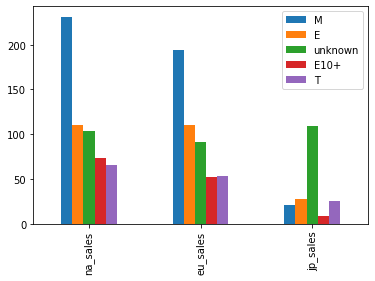

In [ ]:
df_region_rating_liders.plot(kind = 'bar')

Рейтинг E10+ сильно снижает продажи игр. В Японии возрастные рейтинги особенно  плохо сказываются на продажах.


# Исследование статистических показателей

### Статистики в различных жанрах

In [ ]:
pivot_genre_score_statistics = df_cutted.pivot_table(values=['critic_score','user_score'],
                                                     index='genre', 
                                                     aggfunc=['mean','median','var','std', 'count'])
pivot_genre_score_statistics.style.set_properties(**{'text-align': 'center'})

In [ ]:
pivot_genre_score_statistics.loc[:,'std'].sort_values(by = 'user_score',
                                                      ascending = False)['user_score']

genre
Strategy        2.030908
Simulation      1.812585
Sports          1.747672
Racing          1.667597
Platform        1.654447
Shooter         1.437188
Fighting        1.431269
Action          1.374440
Role-Playing    1.278637
Adventure       1.277652
Misc            1.257939
Puzzle          0.888819
Name: user_score, dtype: float64

В пользовательском рейтинге максимальное стандартное отклонение у гонок - 1.42, минимальное у Role-Playing  - 0.86. Чем меньше std, тем меньше выбросов относительно среднего значениея.

In [ ]:
pivot_genre_score_statistics.loc[:,'std'].sort_values(by = 'critic_score', 
                                                      ascending = False)['critic_score']

genre
Sports          15.176345
Simulation      13.922134
Platform        13.832373
Fighting        13.407791
Racing          12.543677
Strategy        12.515968
Shooter         12.505688
Role-Playing    12.282509
Action          12.017949
Adventure       10.967380
Misc            10.145164
Puzzle           6.948221
Name: critic_score, dtype: float64

В рейтинге критиков максимальное стандартное отклонение опять у гонок - 13,4, минимальное у стратегии, Role-Playing также имеет невысокое отклонение - 9,3. Чем меньше std, тем меньше выбросов относительно среднего значениея.

(3.5, 10)

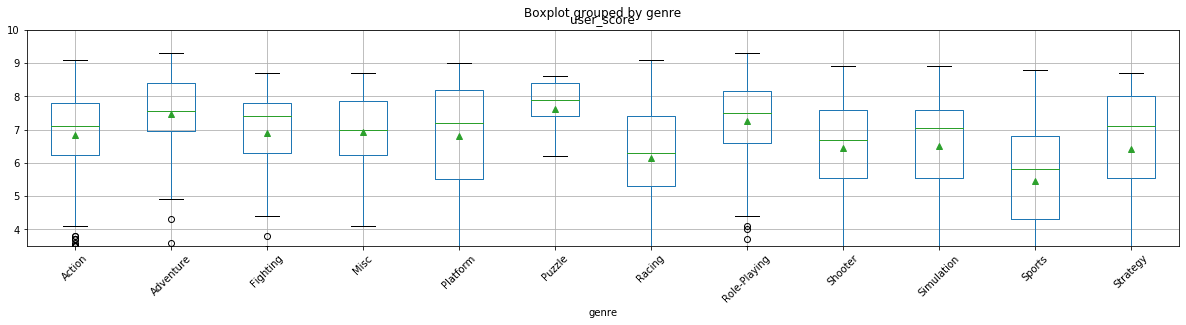

In [ ]:
bx_plt_genre_user_score  = df_cutted.boxplot(column= 'user_score',
                                             by = 'genre', 
                                             showmeans=True,
                                             rot=45, 
                                             figsize=(20,4))
bx_plt_genre_user_score.set_ylim(3.5, 10)

(40, 100)

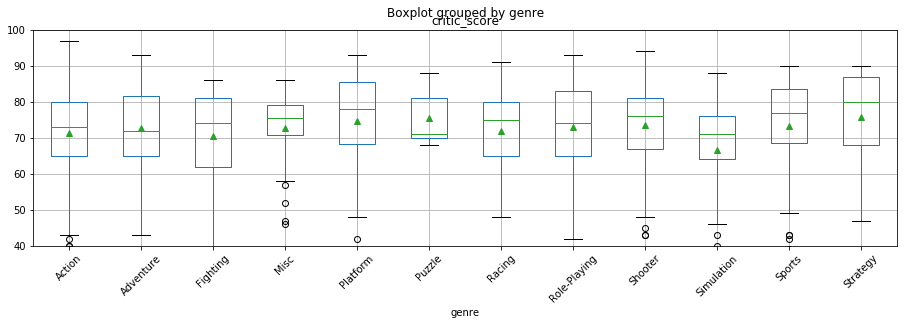

In [ ]:
df_cutted.boxplot(column= 'critic_score',by = 'genre', rot=45, showmeans=True, figsize=(15,4)).set_ylim(40, 100)

### Пользовательские рейтинги по жанрам.

Рейтинги пользователей и критиков  - дискретные величины, т.к. задаются с определенным шагом: у пользователей -0.1, у критиков - 1.
Т.к. всего получается 100 градаций, возмём гистограммы со 100 корзинами.

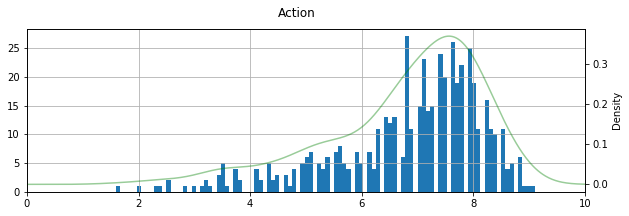

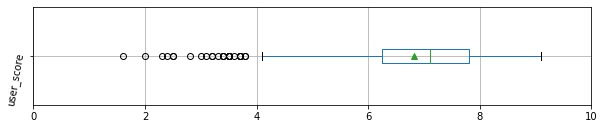

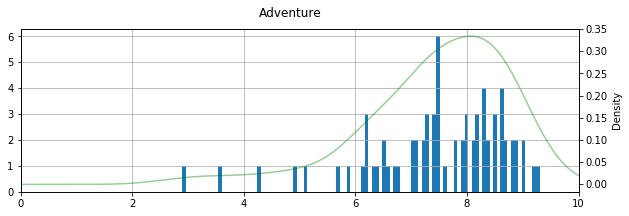

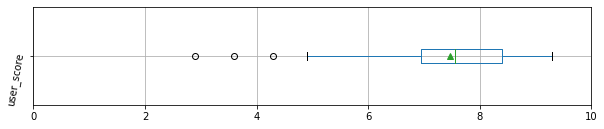

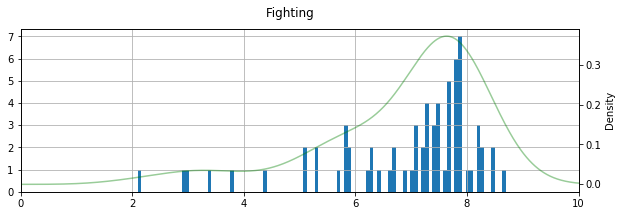

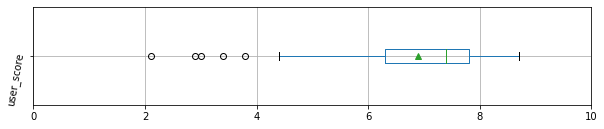

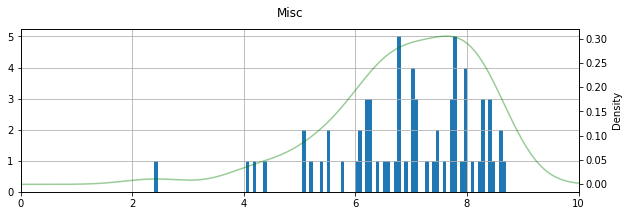

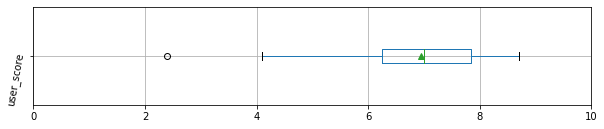

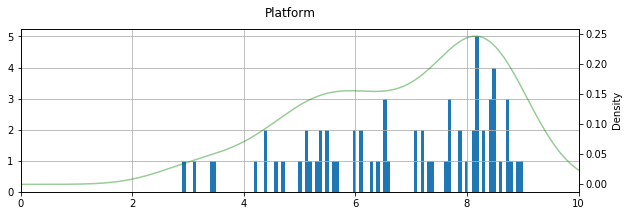

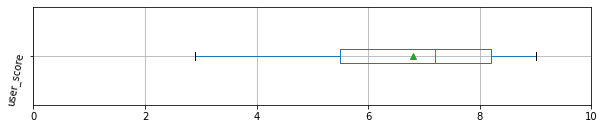

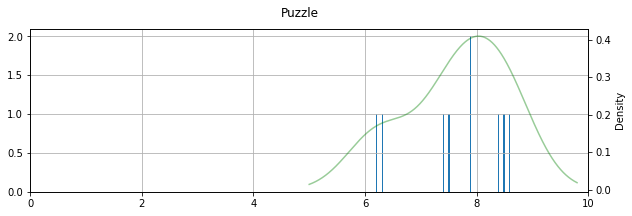

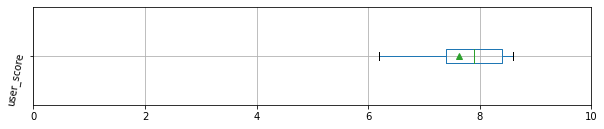

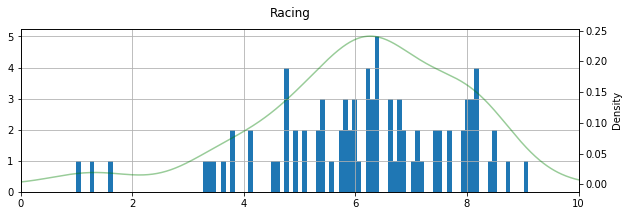

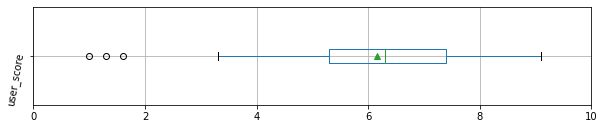

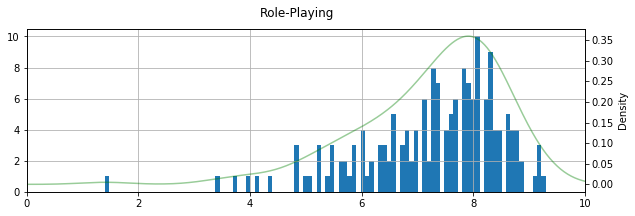

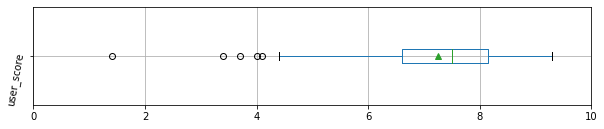

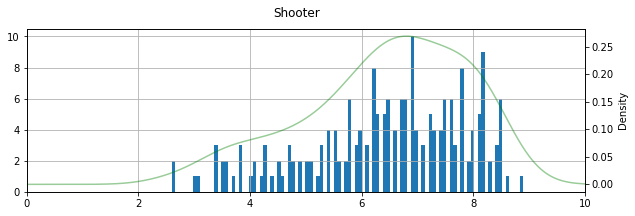

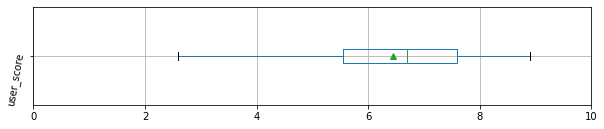

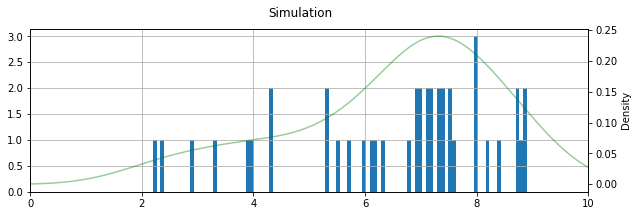

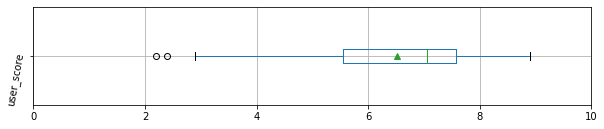

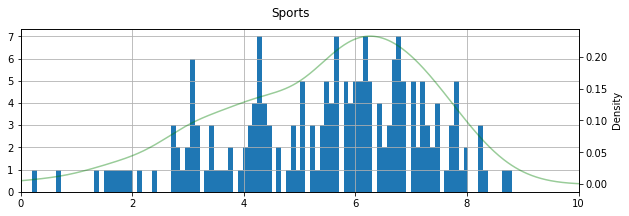

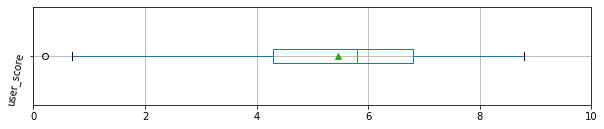

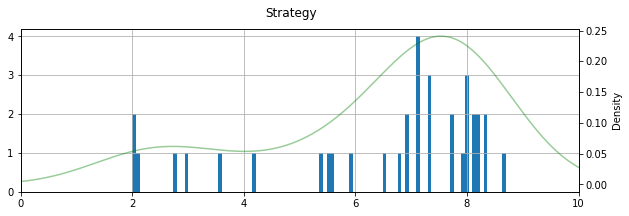

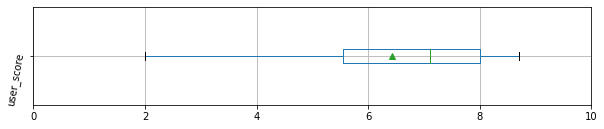

In [ ]:
# для каждого жанра строим гистограмму и под ней ящик с усами
for genre in pivot_genre_score_statistics.index:
  fig, ax = plt.subplots(figsize=(10,3))
  fig.suptitle(genre)
  # гистограмма отфильтрованных по жанру баллов пользователей
  dens = df_cutted.query('genre == @genre')['user_score'].hist(bins = 100,density= False,)
  
  # ядерная оценка плотности(kde) для сглаживания данных
  ax1 = ax.twinx()
  not_dens =df_cutted.query('genre == @genre')['user_score'].plot(kind='kde', ax =ax1, alpha =0.4, color='green').set_xlim(0,10)
  
  # ящики с усами и отметкой среднего
  fig, ax = plt.subplots(figsize=(10,1.8))
  df_cutted.query('genre == @genre').boxplot(column= 'user_score', showmeans=True, vert=False,rot=80).set_xlim(0,10)
  plt.show()


Среднее относительно медианы в пользовательских оценках в основном или левее медианы или приблизительно равно ей. Смещение влево означает значимое количество игр с плохим рейтингом. 

### Рейтинг критиков в различных жанрах

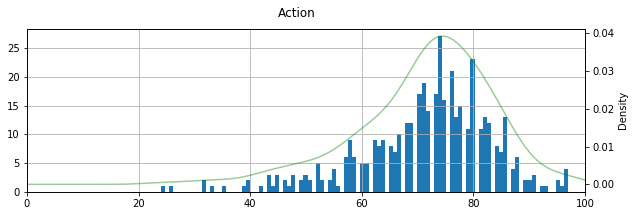

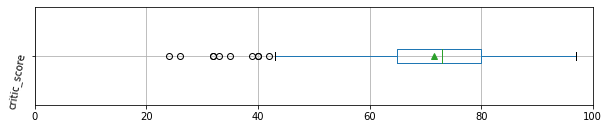

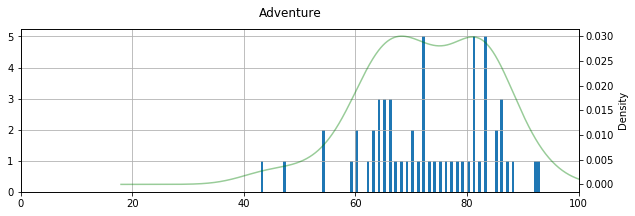

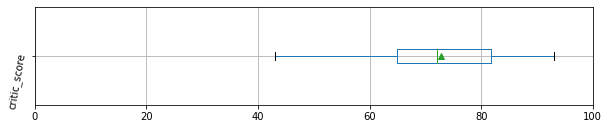

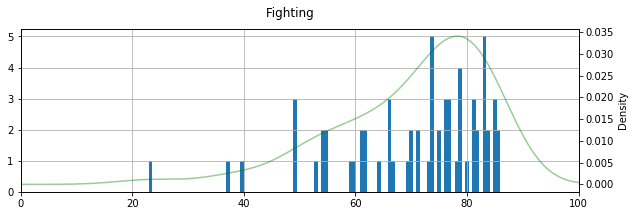

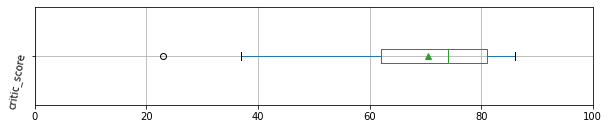

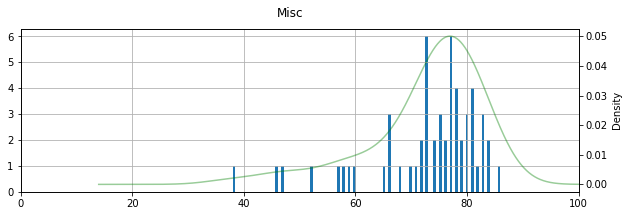

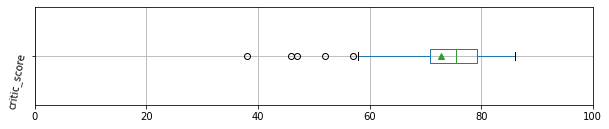

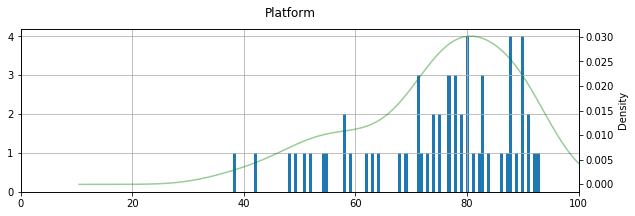

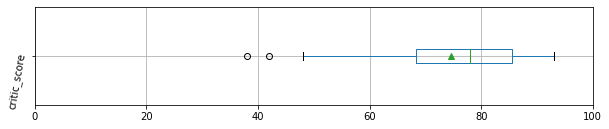

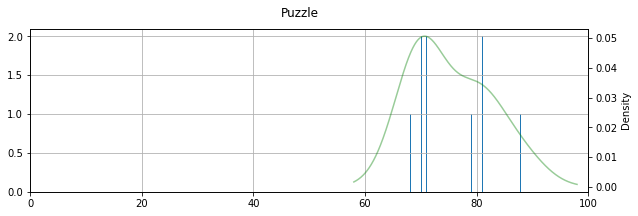

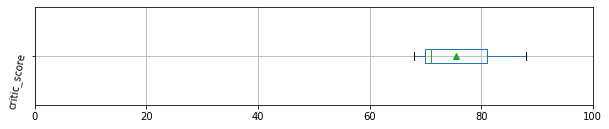

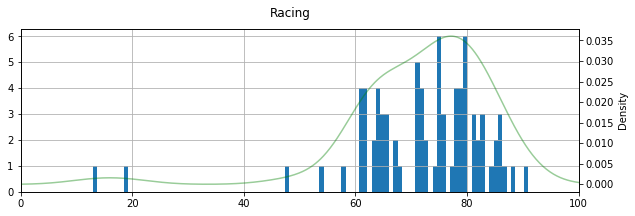

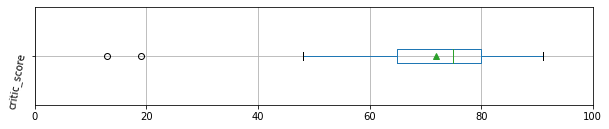

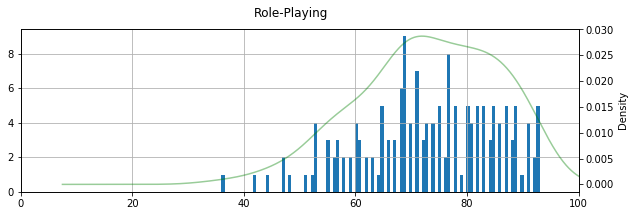

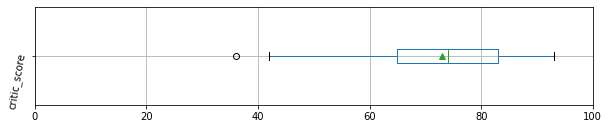

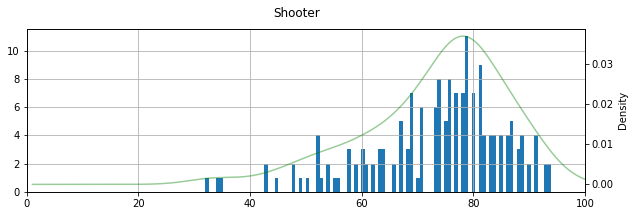

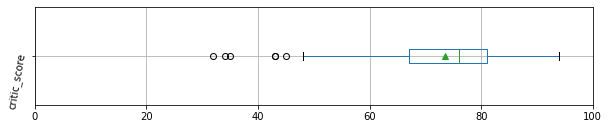

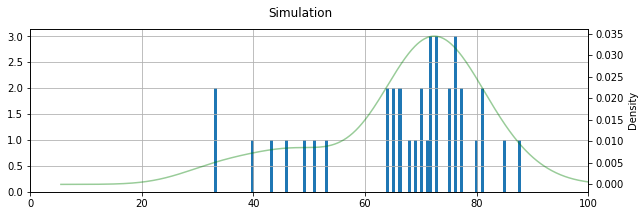

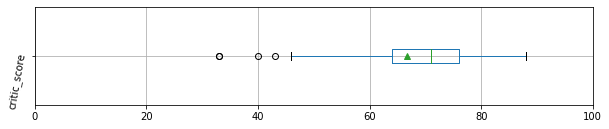

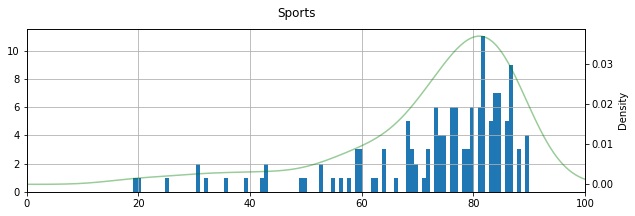

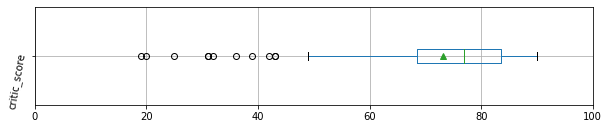

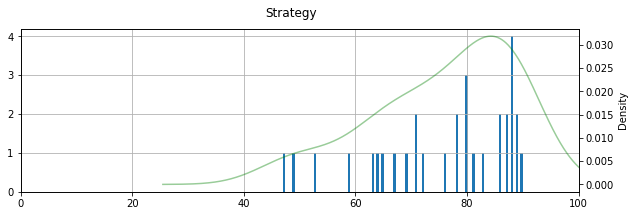

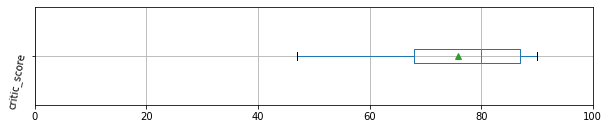

In [ ]:
# для каждого жанра строим гистограмму и под ней ящик с усами
for genre in pivot_genre_score_statistics.index:
  fig, ax = plt.subplots(figsize=(10,3))
  fig.suptitle(genre) # заголовок
  # гистограмма отфильтрованных по жанру баллов критиков
  dens = df_cutted.query('genre == @genre')['critic_score'].hist(bins = 100,density= False,)
  
  # ядерная оценка плотности(kde) для сглаживания данных
  ax1 = ax.twinx()
  not_dens =df_cutted.query('genre == @genre')['critic_score'].plot(kind='kde',
                                                                    ax =ax1, 
                                                                    alpha =0.4, 
                                                                    color='green').set_xlim(0,100)
  # ящики с усами и отметкой среднего
  fig, ax = plt.subplots(figsize=(10,1.8))
  df_cutted.query('genre == @genre').boxplot(column= 'critic_score', 
                                             showmeans=True, 
                                             vert=False,
                                             rot=80).set_xlim(0,100)
  plt.show()

На гистограммах критиков получили несколько иные распределения. Некоторые жанры имеют смещение вправо. В файтингах, гонках и misc есть выбросы с хорошими рейтингами от критиков.

# Проверка гипотез

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [ ]:
df_cutted['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

### Формулировка нулевой и альтернативной гипотезы

H₀ всегда формулируется так, чтобы использовать знак равенства. Другими словами, чтобы все значения, полученные эмпирически, не были экстремальными, а лежали там, где ожидаем их найти. Например, если мы исследуем, не увеличилась ли величина, то нулевая гипотеза будет звучать: «нет, не увеличилась». Если выясняем, есть ли разница между совокупностями, то нулевая гипотеза будет такая: «нет, разницы нет, то есть исследуемые параметры равны».


---
Исходя из H₀ формулируется альтернативная гипотеза H₁. Для этой H₀ она звучит как «среднее генеральной совокупности не равно A».


Тогда наша нулевая гипотеза звучит так: ***Средние пользовательские рейтинги платформ Xbox One и PC одинаковые***


Альтернативная гипотеза H₁: **Средние пользовательские рейтинги платформ Xbox One и PC не равны.**

Проверим гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применив метод scipy.stats.ttest_ind (array1, array2, equal_var)

### Проверка

Посмотрим на дисперсии совокупностей.

In [ ]:
df_cutted.query('platform == "PC"')['user_score'].var()

2.770443997158418

In [ ]:
df_cutted.query('platform == "XOne"')['user_score'].var()

1.9069968429360695

Дисперсии не равны. Значит будем считать equal_var = False.

In [ ]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(df_cutted.query('platform == "PC"')['user_score'].dropna(), df_cutted.query('platform == "XOne"')['user_score'].dropna(), equal_var = False)

print('p-значение:',results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Построю диаграммы, чтобы убедиться, что средние не совпадают.


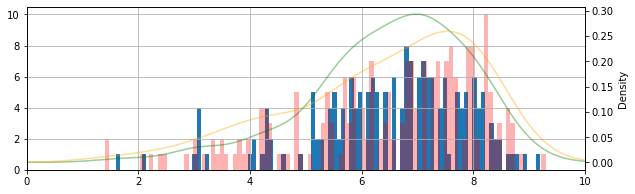

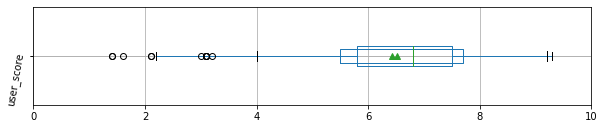

In [ ]:
# гистограммы user_score для XOne и PC
fig, ax = plt.subplots(figsize=(10,3))
dens = df_cutted.query('platform =="XOne"')['user_score'].hist(bins = 100,
                                                               density= False)
dens1 = df_cutted.query('platform =="PC"')['user_score'].hist(bins = 100,
                                                              density= False, 
                                                              color = 'red', 
                                                              alpha =0.3)

# ядерная оценка плотности(kde) для сглаживания данных
ax1 = ax.twinx()
not_dens =df_cutted.query('platform =="XOne"')['user_score'].plot(kind='kde', 
                                                                  ax =ax1, 
                                                                  alpha =0.4, 
                                                                  color='green').set_xlim(0,10)
not_dens1 =df_cutted.query('platform =="PC"')['user_score'].plot(kind='kde', 
                                                                 ax =ax1, 
                                                                 alpha =0.4, 
                                                                 color='orange').set_xlim(0,10)
# ящики с усами
fig, ax = plt.subplots(figsize=(10,1.8))
PC_boxplot = df_cutted.query('platform =="PC"').boxplot(column= 'user_score', 
                                           showmeans=True, 
                                           vert=False,rot=80)
#                                       в Google Colab делал еще разные цвета и форму маркера,
#                                       здесь не получилось
#                                            ,color = 'red',
#                                            meanprops ={ 'marker':'x', 
#                                                        'markeredgecolor' : 'r'})
PC_boxplot.set_xlim(0,10)

df_cutted.query('platform =="XOne"').boxplot(column= 'user_score', 
                                             showmeans=True, 
                                             vert=False,
                                             rot=80, 
                                             widths =0.2,
                                             boxprops ={"alpha" :0.5}, 
                                             whiskerprops={"alpha" :0.5}).set_xlim(0,10)

plt.show()

### Вывод

Полученные диаграммы и результаты расчёта подверждают альтернативную гипотезу: средние с высокой вероятностью совпадают.

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Гипотезы сформулированы и проверены верно.

</div>

## Средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза: **Средние пользовательские рейтинги жанров Action и Sports одинаковые.**

Альтернативная гипотеза: ***Средние пользовательские рейтинги жанров Action и Sports разные***

Посмотрим на дисперсии совокупностей.

In [ ]:
df_cutted.query('genre == "Action"')['user_score'].dropna().var()

1.8890840494348111

In [ ]:
df_cutted.query('genre == "Sports"')['user_score'].dropna().var()

3.0543582685664936

Дисперсии несколько отличаются, поэтому будем считать equal_var = False.

In [ ]:

alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(df_cutted.query('genre == "Action"')['user_score'].dropna(),
                       df_cutted.query('genre == "Sports"')['user_score'].dropna(),equal_var = False)

print('p-значение:',results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 8.449849446620471e-20
Отвергаем нулевую гипотезу


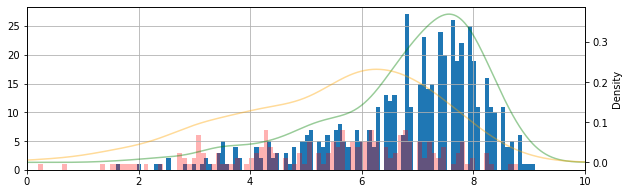

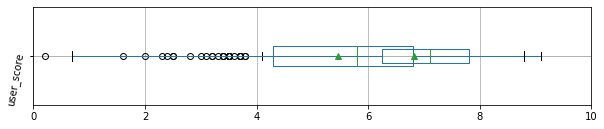

In [ ]:
# гистограммы user_score для Action и Sports
fig, ax = plt.subplots(figsize=(10,3))
dens = df_cutted.query('genre == "Action"')['user_score'].hist(bins = 100,
                                                               density= False)
dens1 = df_cutted.query('genre == "Sports"')['user_score'].hist(bins = 100,
                                                                density= False, 
                                                                color = 'red', 
                                                                alpha =0.3)

# ядерная оценка плотности(kde) для сглаживания данных
ax1 = ax.twinx()
not_dens =df_cutted.query('genre == "Action"')['user_score'].plot(kind='kde', 
                                                              ax =ax1, 
                                                              alpha =0.4, 
                                                              color='green').set_xlim(0,10)
not_dens1 =df_cutted.query('genre == "Sports"')['user_score'].plot(kind='kde',
                                                              ax =ax1, 
                                                              alpha =0.4, 
                                                              color='orange').set_xlim(0,10)

# ящики с усами
fig, ax = plt.subplots(figsize=(10,1.8))
boxplot_Action = df_cutted.query('genre == "Action"').boxplot(column= 'user_score', 
                                             showmeans=True, 
                                             vert=False,
                                             rot=80)
# Также не получилось настроить отображение среднего и цвет
#                                              ,color = 'red',
#                                              meanprops ={ 'marker':'x', 
#                                                          'markeredgecolor' : 'r'})
boxplot_Action.set_xlim(0,10)
df_cutted.query('genre == "Sports"').boxplot(column= 'user_score', 
                                             showmeans=True, 
                                             vert=False,
                                             rot=80, 
                                             widths =0.2,
                                             boxprops ={"alpha" :0.5},
                                             whiskerprops={"alpha" :0.5}).set_xlim(0,10)

plt.show()

### Вывод

Полученные диаграммы и результаты расчёта подверждают альтернативную гипотезу: вероятность совпадения среднего менее 5%.

# Общие выводы.

В результате проделанной работы были очищенны и дополнены данные по играм для различных платформ, проанализированы продажи по платформам и по годам, выявлены самые прибыльные платформы и перспективные в 2017 году, исследованы зависомости продаж от жанров по регионам, продаж от рейтингов пользователей и критиков, влияние рейтинга игры на продажи.

Потенциально прибыльные платформы: PS4 и XOne. Иx можно считать довольно новыми, т.е. есть потенциал роста, а также PlayStation и Xbox предыдущих выпусков зарабатывали хорошие деньги. Игру лучше выбрать в жанре Action с возрастным рейтингом Е или без рейтинга, если, конечно, целевым рынком не является Япония. У Японцев свои предпочтения. Они любят ролевые игры и карманные консоли.  Мнение игроков и критиков на прибыль влияет слабо, но если и прислушиваться, то к мнению критиков.

Вообще видна тенденция на снижение прибыли консольных игр, начиная с 2008 года. Верояно это связано с возникшими конкурентами в виде игр для мобильных устройств: телефонов и планшетов. Поэтому рекомендуется интернет-магазину "Стримчик" присмотреться к растущему рынку мобильных игр.